In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('sensitivity.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
mmass_xe136 = 135.907214 # in gram/mol 
mmass_xe134 = 133.905393 # in gram/mol 
Avogadro = 6.02214076E23 # in 1/mol
bb0n_eff = 0.9598
XeMass_fiducial = 3281.0*1000.0 # in gram
frac_136 = 0.9
frac_134 = 0.1

def GetLivetime(Num, Livetime):
    NXenon136 = (XeMass_fiducial * Avogadro * frac_136) / (frac_136 * mmass_xe136 + frac_134  * mmass_xe134)
    return bb0n_eff * NXenon136 * Livetime  * np.log(2.0) / Num

def GetSignalCount(Halflife, Livetime): 
    NXenon136 = (XeMass_fiducial * Avogadro * frac_136) / (frac_136 * mmass_xe136 + frac_134  * mmass_xe134)
    return bb0n_eff * NXenon136 * Livetime  * np.log(2.0) / Halflife

In [3]:
Livetime = 10.0
def GetT(x):
    return GetLivetime(x,Livetime)
def GetN(x):
    return GetSignalCount(x,Livetime)

In [4]:
data = pd.read_csv('Data/discovery_vs_halflife.csv')

In [5]:
x = np.linspace(np.array(data['Counts'])[0], np.array(data['Counts'])[-1],1000)
Interpolation = np.interp(x, data['Counts'], data['Sigma'])

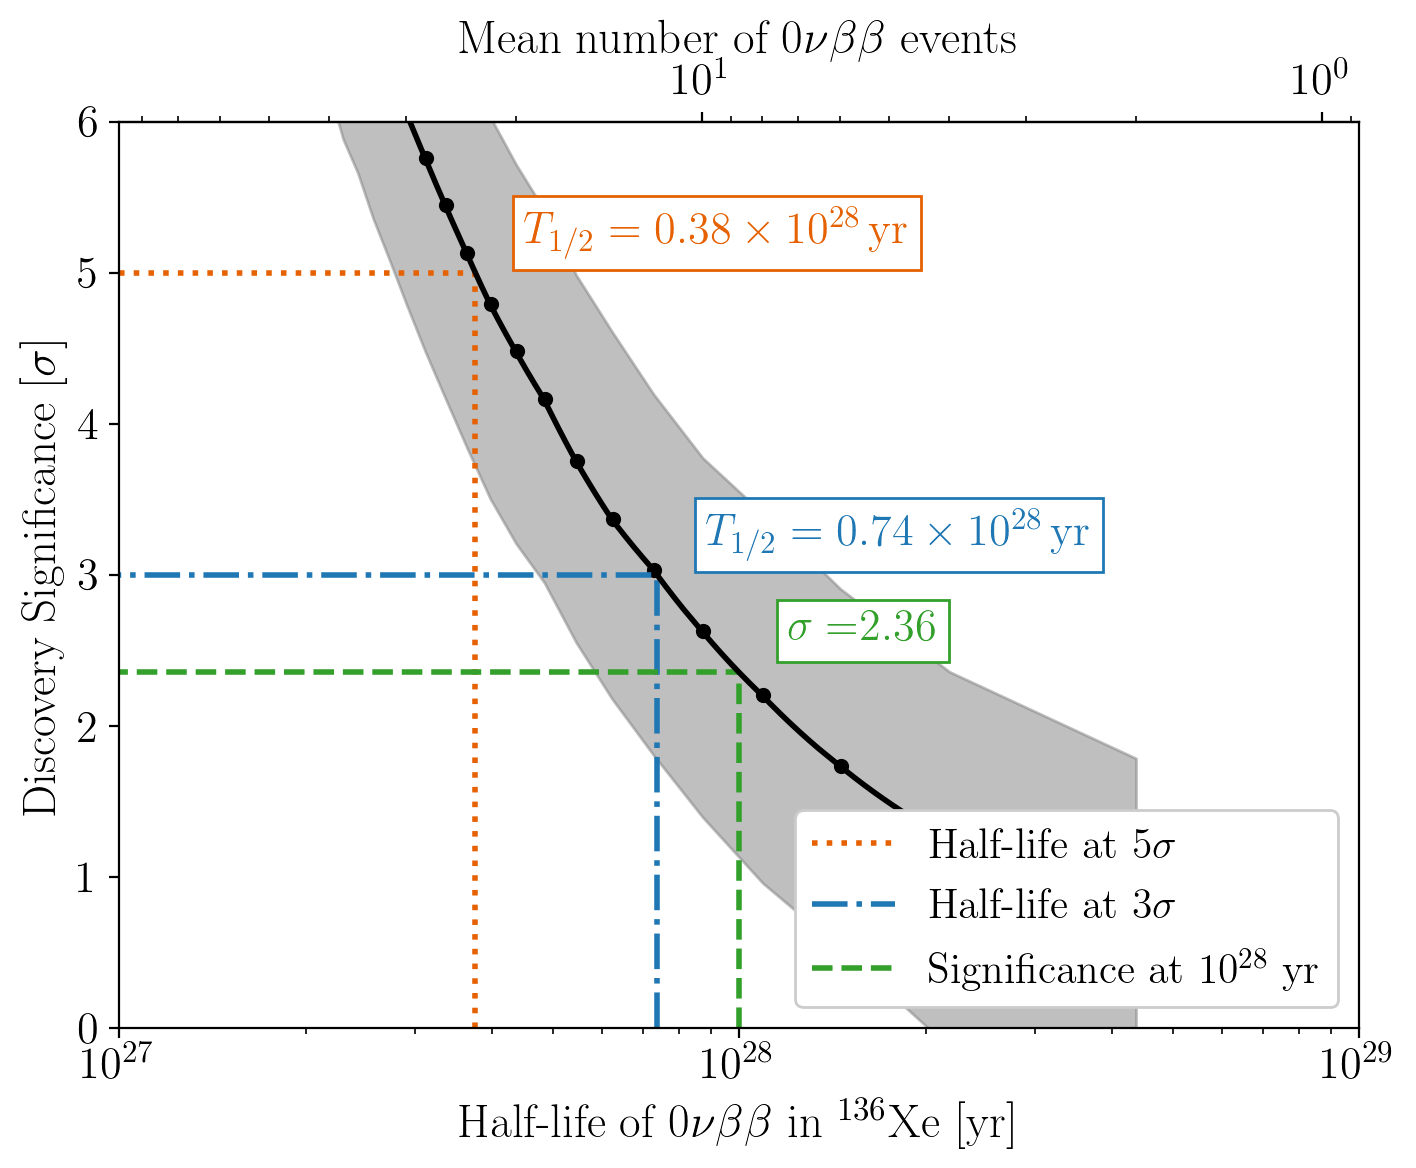

In [7]:
fig, ax = plt.subplots()


ax.fill_between(data['Halflife'], data['68_Low'], data['68_High'], color='grey', alpha=0.5)
ax.plot(GetT(x), Interpolation, label='', ls='-', color='k')
ax.scatter(data['Halflife'], data['Sigma'], color='k', marker='.', s=80)


Cut_3sigma = np.where( np.abs(Interpolation-3) == np.min(np.abs(Interpolation-3)) )
Cut_5sigma = np.where( np.abs(Interpolation-5) == np.min(np.abs(Interpolation-5)) )
Cut_10to28 = np.where( np.abs(GetT(x)-1E28) == np.min(np.abs(GetT(x)-1E28)) )


ax.hlines(Interpolation[Cut_5sigma], xmin=1e27, xmax=GetT(x[Cut_5sigma]), color=colors[1], ls=':')
ax.vlines(GetT(x[Cut_5sigma]), ymin=0, ymax=Interpolation[Cut_5sigma], color=colors[1], ls=':', label='Half-life at 5$\sigma$')

ax.hlines(3, xmin=0, xmax=GetT(x[Cut_3sigma]), color=colors[0], ls='-.')
ax.vlines(GetT(x[Cut_3sigma]), ymin=0, ymax=3, color=colors[0], ls='-.', label='Half-life at 3$\sigma$')

ax.hlines(Interpolation[Cut_10to28], xmin=1e20, xmax=1e28, color=colors[2], ls='--')
ax.vlines(1E28, ymin=0, ymax=Interpolation[Cut_10to28], color=colors[2], ls='--', label='Significance at $10^{28}$ yr')


dp_base1 = GetLivetime(x[Cut_3sigma], Livetime)/1E28
dp_exp1 = np.floor(np.log10(GetLivetime(x[Cut_3sigma], Livetime))).astype(int) + 1 
dp_base2 = GetT(x[Cut_5sigma])/1E28
dp_exp2 = np.floor(np.log10(GetT(x[Cut_5sigma]))).astype(int) + 1 
dp_base3 = GetLivetime(x[Cut_3sigma], Livetime)/1E28
dp_exp3 = np.floor(np.log10(GetLivetime(x[Cut_3sigma], Livetime))).astype(int)

ax.text(x=GetT(x[Cut_3sigma])*1.2, y=3.2, 
        s=r'$T_{1/2}=%.2f \times 10^{%d}\,\mathrm{yr} $' % (dp_base1, dp_exp1), color=colors[0], 
        fontsize=16, bbox=dict(facecolor='w', edgecolor=colors[0], alpha=1))
ax.text(x=GetT(x[Cut_5sigma])*1.2, y=5.2, 
        s=r'$T_{1/2}=%.2f \times 10^{%d}\,\mathrm{yr} $' % (dp_base2, dp_exp2), color=colors[1], 
        fontsize=16, bbox=dict(facecolor='w', edgecolor=colors[1], alpha=1))
ax.text(x=1E28*1.2, y=Interpolation[Cut_10to28]+0.2, 
        s=r'$\sigma=$%.2f' % Interpolation[Cut_10to28], color=colors[2], 
        fontsize=16, bbox=dict(facecolor='w', edgecolor=colors[2], alpha=1))


ax.set_xscale('log')
ax.set_xlim(1e27, 1e29)
ax.set_ylim(0,6)
ax.set_xlabel('Half-life of $0\\nu\\beta\\beta$ in ${}^{136}\mathrm{Xe}$ [yr]')
ax.set_ylabel(r'Discovery Significance [$\sigma$]')
ax.legend(loc='lower right', fontsize=15, framealpha=1.0)

secax = ax.secondary_xaxis('top', functions=(GetN, GetT))
secax.set_xlabel(r'Mean number of $0\nu\beta\beta$ events')

plt.savefig('discovery_significance_vs_halflife.png')